# Youtube Dataset Analysis
1. Business Insights from EDA
2. Popular Title Generator with LSTM (To genrate titles with the most popular words!)

### Business Insights from EDA (Part 1)
1. Entertainment is the most popular category in Youtube. However, by looking at the boxplot, the variabtion of Entertainment is also the highest. It might due to the high quality divergence among different Youtubers.
2. For the key metric: #likes/#views, the aggregated maximum over time is very fluctuated, while the rest three (mean, min and median) are quite stable over time.
3. In Entertainment category, the top popular video tags are: official, trailor, challenge, Marvel etc, which are quite common sense words and are known to be popular. A LSTM model is built which can help Youtubers to generate attractive Youtube Video Titles, leading to an increase in subsription!


In [3]:
# import packages
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


from tqdm import tqdm
import string
import random
import operator
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
import nltk

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# nltk tools
import nltk
# nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer


# set seeds for reproducability
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(2)
seed(1)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
from google.colab import files
files.upload()

Saving US_category_id.json to US_category_id.json


{'US_category_id.json': b'{\r\n "kind": "youtube#videoCategoryListResponse",\r\n "etag": "\\"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM\\"",\r\n "items": [\r\n  {\r\n   "kind": "youtube#videoCategory",\r\n   "etag": "\\"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ\\"",\r\n   "id": "1",\r\n   "snippet": {\r\n    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",\r\n    "title": "Film & Animation",\r\n    "assignable": true\r\n   }\r\n  },\r\n  {\r\n   "kind": "youtube#videoCategory",\r\n   "etag": "\\"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA\\"",\r\n   "id": "2",\r\n   "snippet": {\r\n    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",\r\n    "title": "Autos & Vehicles",\r\n    "assignable": true\r\n   }\r\n  },\r\n  {\r\n   "kind": "youtube#videoCategory",\r\n   "etag": "\\"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg\\"",\r\n   "id": "10",\r\n   "snippet": {\r\n    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",\r\n    "title": "Music",\r\n    "assignable": t

In [0]:
df = pd.read_csv("USvideos.csv")

In [0]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [8]:
# convert data type

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m') #parsing
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['category_id'] = df['category_id'].astype(str)

df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [0]:
id_to_category = {}

with open('US_category_id.json' , 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
        
df['category'] = df['category_id'].map(id_to_category)

In [0]:
df.groupby('category').size()

category
Autos & Vehicles          384
Comedy                   3457
Education                1656
Entertainment            9964
Film & Animation         2345
Gaming                    817
Howto & Style            4146
Music                    6472
News & Politics          2487
Nonprofits & Activism      57
People & Blogs           3210
Pets & Animals            920
Science & Technology     2401
Shows                      57
Sports                   2174
Travel & Events           402
dtype: int64

Feature Engineering

In [0]:
df["pref_ratio"] = df["likes"] / df["dislikes"]
df["percent_comment"] = df["comment_count"] / df["views"]
df['percent_like'] = df['likes'] / df['views']
df["percent_reaction"] = (df["likes"] + df["dislikes"]) / df["views"]

df['publish_date'] = df['publish_time'].dt.date
df['publish_tym'] = df['publish_time'].dt.time

Distribution of Critial Metrics

In [0]:
df.head()

In [33]:
df_mean = df.groupby('trending_date').mean().percent_like
df_max = df.groupby('trending_date').max().percent_like
df_min = df.groupby('trending_date').min().percent_like
df_median = df.groupby('trending_date').median().percent_like

df_aggregate = pd.concat([df_mean, df_max, df_min, df_median], axis=1, ignore_index=True)
df_aggregate.columns = ['mean','max','min','median']
df_aggregate

,mean,max,min,median
trending_date,,,,
2017-11-14,0.036657,0.166072,0.000000,0.034460
2017-11-15,0.033036,0.137174,0.000675,0.030336
2017-11-16,0.032366,0.129881,0.000238,0.028600
2017-11-17,0.035708,0.270613,0.000505,0.028899
2017-11-18,0.039646,0.228463,0.000423,0.032337
...,...,...,...,...
2018-06-10,0.034886,0.152053,0.000502,0.027226
2018-06-11,0.034650,0.150946,0.000504,0.027357
2018-06-12,0.034840,0.189004,0.000508,0.028280


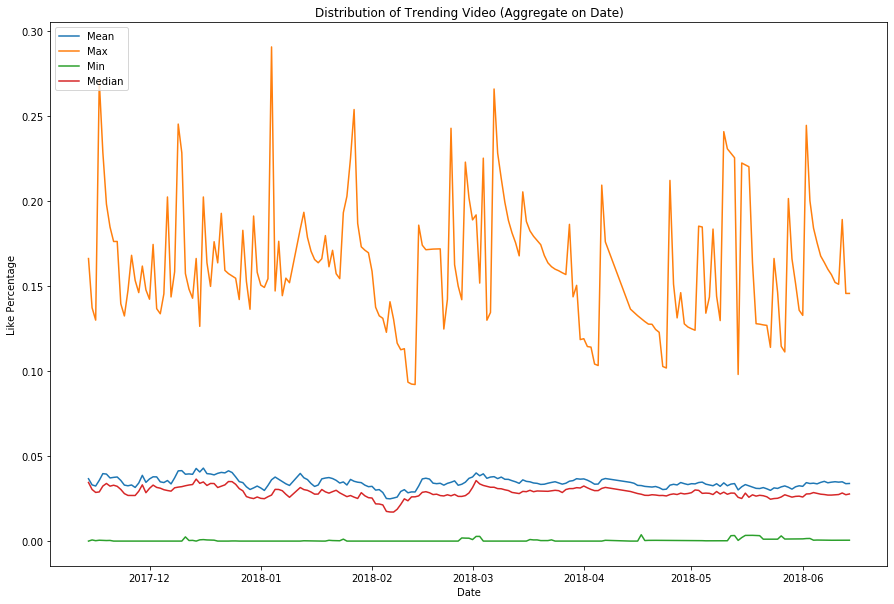

In [42]:


fig = plt.figure(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel("Like Percentage")
plt.title("Distribution of Trending Video (Aggregate on Date)")
ax1 = fig.add_subplot(111)

ax1.plot(df_aggregate.index, df_aggregate['mean'], label='Mean')
ax1.plot(df_aggregate.index, df_aggregate['max'], label='Max')
ax1.plot(df_aggregate.index, df_aggregate['min'], label='Min')
ax1.plot(df_aggregate.index, df_aggregate['median'], label='Median')
ax1.legend(loc=2)

Correlation Matrix

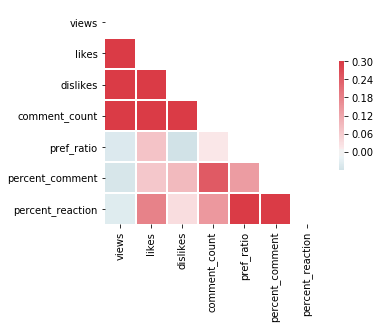

In [0]:
contvars = df[["views", "likes", "dislikes", "comment_count", "pref_ratio", "percent_comment", "percent_reaction"]]

corr = contvars.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

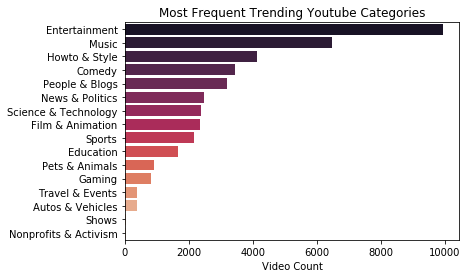

In [0]:
by_cat = df.groupby(["category"]).size().sort_values(ascending = False)
sns.barplot(by_cat.values, by_cat.index.values, palette = "rocket")
plt.title("Most Frequent Trending Youtube Categories")
plt.xlabel("Video Count")
plt.show()

In [0]:
view_count = np.log(df['views']+1 )
likes = np.log(df['likes']+1)
dislikes = np.log(df['dislikes']+1)
comment = np.log(df['comment_count']+1)
pref_ratio = np.log(df['pref_ratio']+1)
percent_comment = np.log(df['percent_comment']+1)
percent_reaction = np.log(df['percent_reaction']+1)

data_for_plot = pd.concat([view_count,likes,dislikes,comment, pref_ratio, percent_comment, percent_reaction], axis=1)
data_for_plot['category'] = df['category']
data_for_plot = data_for_plot[(data_for_plot != 0)]


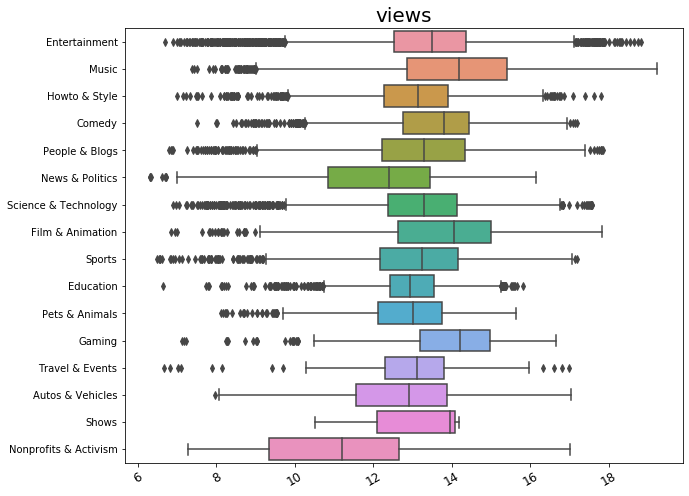

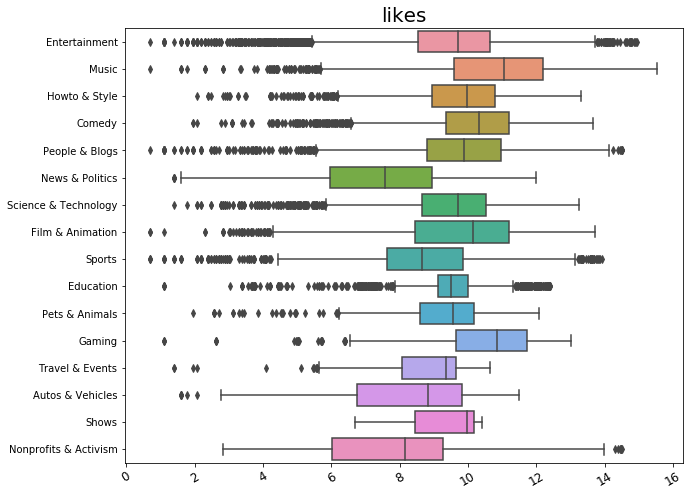

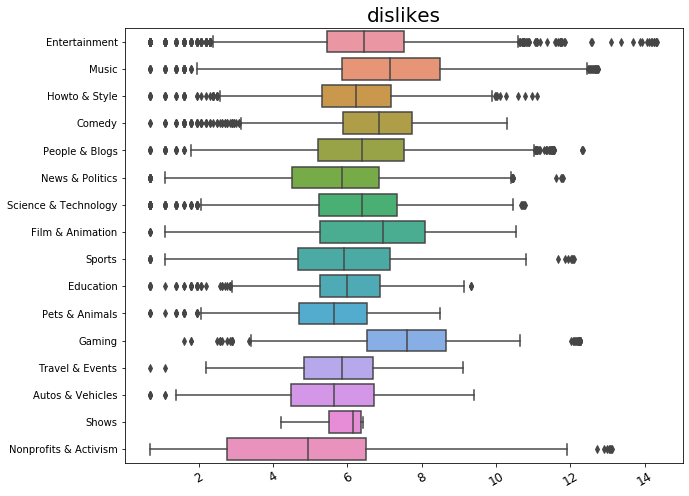

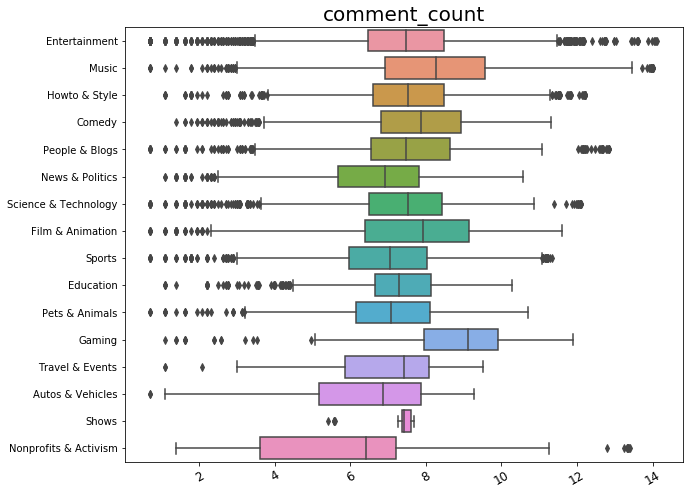

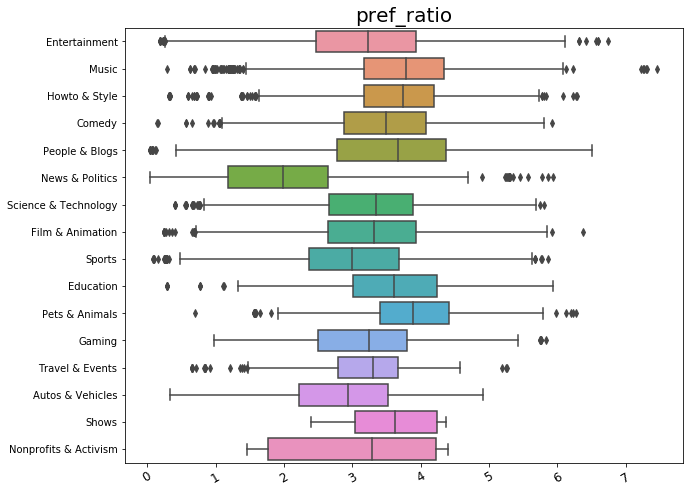

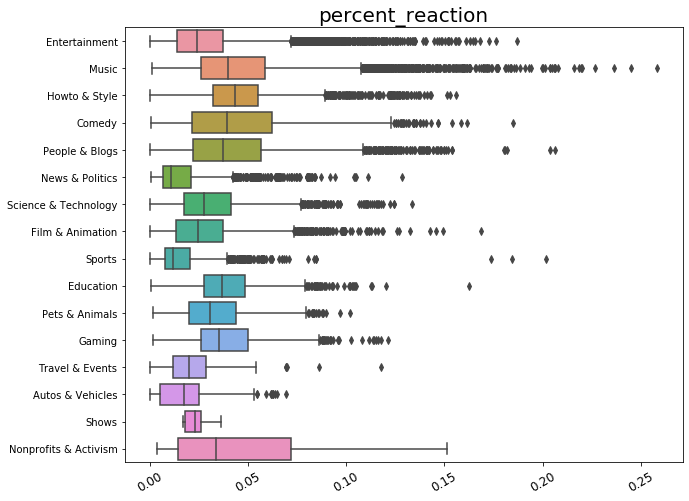

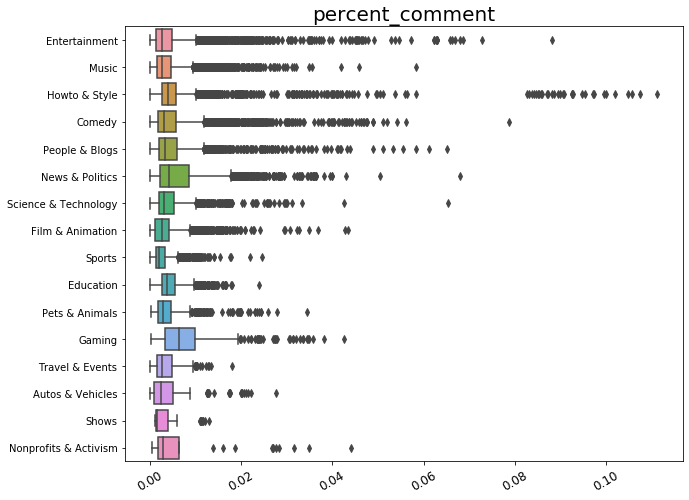

In [10]:
def variation_plot(df, var):
  plt.figure(figsize=(10,8))
  sns.boxplot(x=var, y = 'category', data=df, order = df['category'].value_counts().index )
  plt.xticks(rotation=30,fontsize=12)
  plt.xlabel('')
  plt.ylabel('')
  plt.title(var, fontsize=20)
  plt.show()

for i in ["views", "likes", "dislikes", "comment_count", "pref_ratio", "percent_reaction", "percent_comment"]:
    variation_plot(data_for_plot, i)


Create Wrodcloud for the most frequent words in Entertainment

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

en_stopwords = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
ent_data = df.loc[df['category'] == 'Entertainment']
Q1 = ent_data.views.quantile(0.25)
Q2 = ent_data.views.quantile(0.5)
Q3 = ent_data.views.quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q2)
print(Q3)

#popular_videos=three_countries.loc[three_countries.views > (Q3 + 1.5 * IQR)]
popular_videos = ent_data.loc[df.views > (Q2)]

ent_data['popular'] = 0
ent_data.loc[ent_data.views > (Q2),'popular']=1

ent_data['popular'].value_counts()

273394.75
734704.0
1733746.25


1    4982
0    4982
Name: popular, dtype: int64

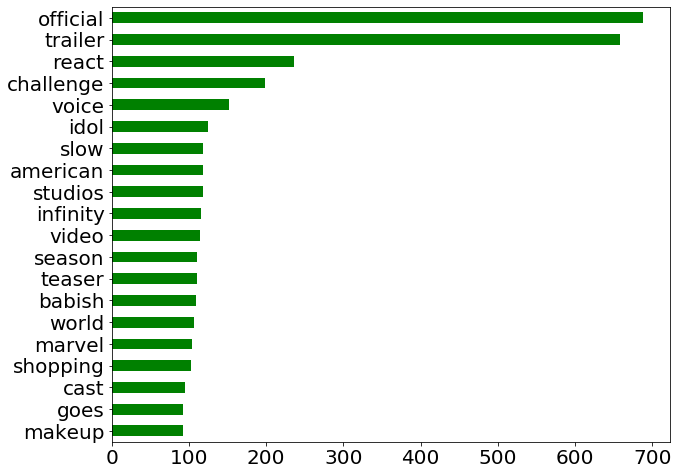

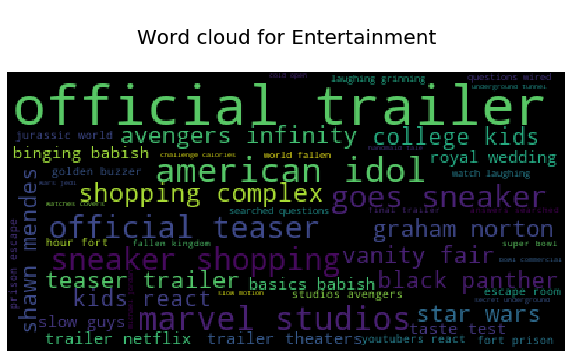

In [13]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = [ c for c in mytokens if not c.isdigit()]
    mytokens = [ t for t in mytokens if len(t) > 3]
    mytokens = " ".join([i for i in mytokens])
    return mytokens
popular = ent_data["title"][ent_data["popular"] == 1].apply(spacy_tokenizer)

def word_generator(text):
    word = list(text.split())
    return word
popular_words = popular.apply(word_generator)

def word_plot(words,my_color):
    slist =[]
    for x in words:
        slist.extend(x)
    
    # histogram
    fig = plt.figure(figsize=(10, 8))
    pd.Series(slist).value_counts()[:20].sort_values(ascending=True).plot(kind='barh',fontsize=20, color=my_color)
    plt.show()

    #wordcloud
    cloud = WordCloud(background_color = 'black', max_words=50, max_font_size=40, random_state=42)
    cloud.generate(' '.join(slist))
    
    plt.figure(figsize = (10,10),facecolor = None)
    plt.imshow(cloud)
    plt.axis('off')
    plt.title("\nWord cloud for {}\n".format('Entertainment'), fontsize=20)

word_plot(popular_words,'green')

Generate Popular Youtube Title with LSTM

In [18]:
Q1 = ent_data.views.quantile(0.25)
Q2 = ent_data.views.quantile(0.5)
Q3 = ent_data.views.quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q2)
print(Q3)

popular_videos = df.loc[df.views > (Q3)]

df['popular'] = 0
df.loc[df.views > (Q2),'popular']=1

df['popular'].value_counts()
# df.head()

273394.75
734704.0
1733746.25


0    21248
1    19701
Name: popular, dtype: int64

In [19]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

popular_total = df["title"][df["popular"] == 1].apply(spacy_tokenizer)
inp_sequences, total_words = get_sequence_of_tokens(popular_total)
inp_sequences[:10]

[[348, 159],
 [348, 159, 1227],
 [49, 2771],
 [49, 2771, 59],
 [49, 2771, 59, 289],
 [49, 2771, 59, 289, 23],
 [49, 2771, 59, 289, 23, 926],
 [574, 1228],
 [574, 1228, 174],
 [574, 1228, 174, 184]]

In [0]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [21]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 10)            46640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4664)              471064    
Total params: 562,104
Trainable params: 562,104
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(predictors, label, epochs=50, verbose=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [0]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [25]:
print (generate_text("trailer", 7, model, max_sequence_len))
print (generate_text("Merry Christmas", 5, model, max_sequence_len))
print (generate_text("official", 4, model, max_sequence_len))


Trailer Coming Makes History Dance Bryce Dallas Door
Merry Christmas Dominoes Christmas Card Official Video
Official Video Havana Pentatonix Favorite
